In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In [2]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

transactions_merged = pd.merge(transactions_df, products_df, on="ProductID", how="left")
full_data = pd.merge(transactions_merged, customers_df, on="CustomerID", how="left")

In [15]:
customer_summary = full_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',       
    'TransactionID': 'count', 
    'Quantity': 'sum',        
    'Category': lambda x: x.nunique(),  
}).rename(columns={
    'TransactionID': 'TransactionCount',
    'Category': 'UniqueCategories'
}).reset_index()


customer_profiles = customers_df[['CustomerID', 'Region', 'SignupDate']]
customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['CustomerLifetime'] = (pd.Timestamp.now() - customer_profiles['SignupDate']).dt.days

# Merging
customer_data = pd.merge(customer_summary, customer_profiles, on="CustomerID")


C:\Users\KIIT\AppData\Local\Temp\ipykernel_28552\2634261189.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])


In [16]:
le = LabelEncoder()
customer_data['Region'] = le.fit_transform(customer_data['Region'])

In [17]:
customer_data.drop(['CustomerID', 'SignupDate'], axis=1, inplace=True)

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

In [19]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

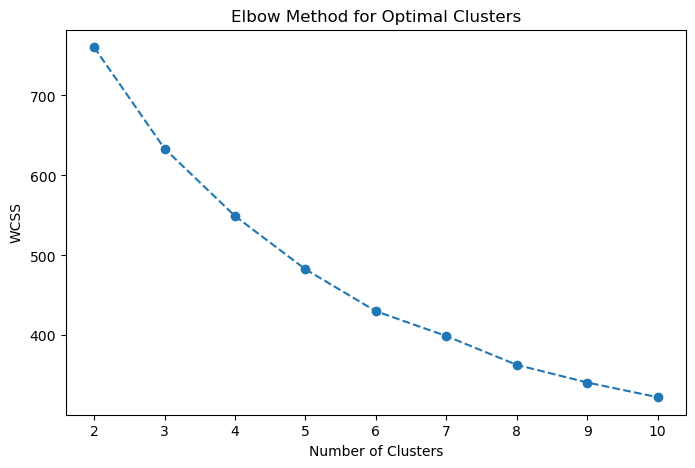

In [22]:
#The ELBOW METHOD
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
optimal_clusters = 8  # Adjusting according to elbow method graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_data)

# CLUSTERS
customer_data['Cluster'] = kmeans_clusters

db_index = davies_bouldin_score(scaled_data, kmeans_clusters)
silhouette_avg = silhouette_score(scaled_data, kmeans_clusters)


C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


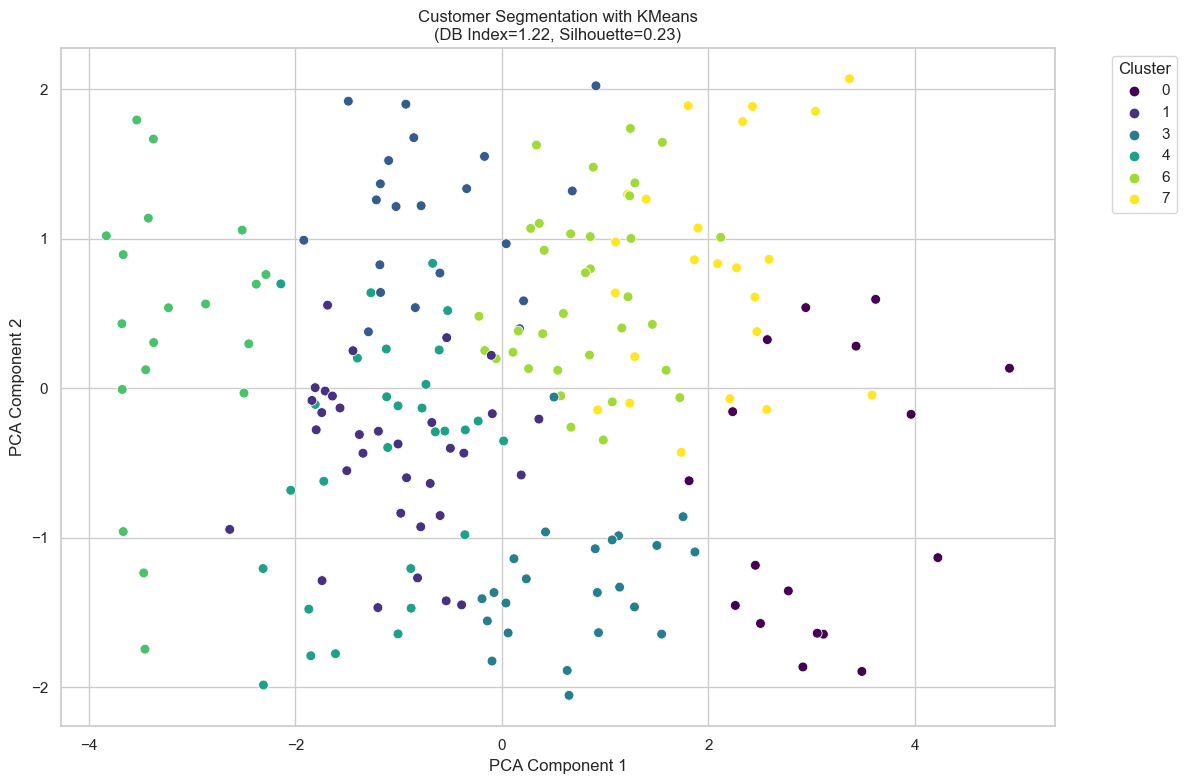

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_clusters, palette="viridis", s=50
)
plt.title(f"Customer Segmentation with KMeans\n(DB Index={db_index:.2f}, Silhouette={silhouette_avg:.2f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [25]:
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")


Optimal Number of Clusters: 8
Davies-Bouldin Index: 1.22
Silhouette Score: 0.23


In [26]:
customer_data.to_csv('KMeans_Clustered_Customers.csv', index=False)
#MADE CSV FOR IT ALSO